In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pytz
import re
import os
import logging
import matplotlib.ticker as ticker

In [2]:
basedir = "../data/03-communication-efficiency/2024-08-10/17-19/"
add_redis_to_feedservice = True # will add redis container energy to feedservice total energy

outputdir = basedir+"output/"
os.makedirs(outputdir, exist_ok=True)
locust_data_history_file = basedir + "data_stats_history.csv"
locust_data_file = basedir + "data_stats.csv"
kepler_data_file = basedir+"kepler.csv"
pdu_data_file = basedir+"pdu.csv"
service_metrics_data_file = basedir+"service_metrics.csv"
logging.basicConfig(level=logging.INFO,
                    filename=outputdir+"run.log",
                    format='%(asctime)s %(levelname)s - %(message)s',
                    datefmt='%H:%M:%S',
                    filemode='a')
logging.getLogger().addHandler(logging.StreamHandler())
logging.info("Starting")
stages = [
    {"users": 100, "spawn_rate": 1},
    {"users": 200, "spawn_rate": 1},
    {"users": 300, "spawn_rate": 1},
    {"users": 400, "spawn_rate": 1},
    {"users": 500, "spawn_rate": 1}
]

valid_users = set()
for stage in stages:
    valid_users.add(stage['users'])

Starting


In [3]:
locust_df = pd.read_csv("%s" % locust_data_history_file)

# timestamp to datetime
locust_df['Timestamp'] = pd.to_datetime(locust_df['Timestamp'], unit='s')

# convert datetime to europe berline timezone and use it as index
germany_tz = pytz.timezone('Europe/Berlin')
locust_df['Timestamp'] = locust_df['Timestamp'].dt.tz_localize('UTC').dt.tz_convert(germany_tz)
locust_df.set_index('Timestamp', inplace=True)

# Delete unrelevant data
locust_df.drop(columns=['Type'], inplace=True)
locust_df = locust_df[locust_df['Total Request Count'] != 0]

# Only look at the "wanted" stages (not the step-up between stages)
locust_df = locust_df[locust_df['User Count'].isin(valid_users)]
locust_df

,User Count,Name,Requests/s,Failures/s,50%,66%,75%,80%,90%,95%,...,99.9%,99.99%,100%,Total Request Count,Total Failure Count,Total Median Response Time,Total Average Response Time,Total Min Response Time,Total Max Response Time,Total Average Content Size
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-08-10 17:27:17+02:00,100,Aggregated,0.0,0.0,63.0,80.0,87.0,130.0,180.0,180.0,...,15000.0,15000.0,15000.0,42,0,59.0,437.795716,42.812207,15136.248080,6723.809524
2024-08-10 17:27:18+02:00,100,Aggregated,0.0,0.0,61.0,70.0,92.0,120.0,170.0,320.0,...,15000.0,15000.0,15000.0,118,0,61.0,466.278183,42.812207,15150.038192,8295.016949
2024-08-10 17:27:19+02:00,100,Aggregated,86.0,0.0,63.0,72.0,89.0,100.0,170.0,240.0,...,15000.0,15000.0,15000.0,202,0,63.0,310.443391,42.812207,15150.038192,9636.212871
2024-08-10 17:27:20+02:00,100,Aggregated,93.5,0.0,62.0,74.0,90.0,100.0,170.0,210.0,...,15000.0,15000.0,15000.0,335,0,62.0,219.744783,42.812207,15150.038192,6797.895522
2024-08-10 17:27:21+02:00,100,Aggregated,102.0,0.0,60.0,70.0,85.0,95.0,160.0,210.0,...,15000.0,15000.0,15000.0,456,0,60.0,180.974544,42.812207,15150.038192,5742.883772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-10 19:06:24+02:00,500,Aggregated,468.9,0.0,120.0,170.0,210.0,250.0,390.0,590.0,...,3100.0,4600.0,9100.0,537896,70,120.0,193.129026,37.821155,9129.134109,13640.640020
2024-08-10 19:06:25+02:00,500,Aggregated,461.4,0.0,120.0,170.0,210.0,250.0,390.0,590.0,...,3100.0,4600.0,9100.0,538261,70,120.0,193.134145,37.821155,9129.134109,13639.758860
2024-08-10 19:06:26+02:00,500,Aggregated,470.9,0.0,120.0,170.0,210.0,250.0,390.0,590.0,...,3100.0,4600.0,9100.0,538822,70,120.0,193.129077,37.821155,9129.134109,13645.341614


In [4]:
# Get the min and max index (time) for the current stage
start_time, end_time = locust_df.index.min(), locust_df.index.max()

# Convert the timezoned datetime to naive datetime (UTC or localize as needed)
start_time = start_time.tz_convert("Europe/Berlin").tz_localize(None)
end_time = end_time.tz_convert("Europe/Berlin").tz_localize(None)
logging.info("Start: %s ; End: %s", start_time, end_time)

Start: 2024-08-10 17:27:17 ; End: 2024-08-10 19:06:28


In [5]:
# Determine the appropriate unit for the total energy consumed
def convert_energy(total_energy_joules):
    if total_energy_joules >= 1e6:  # 1 Megajoule = 1,000,000 Joules
        energy_unit = "MJ"
        total_energy = total_energy_joules / 1e6
    elif total_energy_joules >= 1e3:  # 1 Kilojoule = 1,000 Joules
        energy_unit = "kJ"
        total_energy = total_energy_joules / 1e3
    else:
        energy_unit = "J"
        total_energy = total_energy_joules
    return total_energy, energy_unit

def transform_joules(energy, from_unit, to_unit):
    # Conversion factors to Joules
    conversion_to_joules = {
        "MJ": 1e6,
        "kJ": 1e3,
        "J": 1
    }
    
    if from_unit not in conversion_to_joules:
        raise ValueError(f"Unknown from_unit: {from_unit}")
    
    if to_unit not in conversion_to_joules:
        raise ValueError(f"Unknown to_unit: {to_unit}")
    
    # Convert from original unit to Joules
    energy_in_joules = energy * conversion_to_joules[from_unit]
    
    # Convert from Joules to the target unit
    energy_in_target_unit = energy_in_joules / conversion_to_joules[to_unit]
    
    return energy_in_target_unit

## Calculate the total Energy consumption using Kepler & PDU Data

Note 1: Kepler data consists of the kepler_container_joules_total metric, which tracks the aggregated/consumed amount of joules for each container
If a container is stopped then the responding columns values have no values. The same for containers which are started in the future.
To sum up the energy over the time we will start all columns which do not start with values with zero's and continue on missing values with the last seen value. 

In [6]:
pdu_df = pd.read_csv(pdu_data_file,  parse_dates=['Time'])
pdu_df['Time'] = pd.to_datetime(pdu_df['Time'])  # Ensure consistent timezone
# Ensure the DataFrame is sorted by Time
pdu_df = pdu_df.sort_values(by='Time')
pdu_df.index = pd.to_datetime(pdu_df.index)

# Function to remove ' W' and convert to numeric
def strip_w_convert(series):
    return pd.to_numeric(series.str.replace(' W', ''), errors='coerce')

# Apply the function to all columns except 'Time'
for column in pdu_df.columns:
    if column != 'Time':
        pdu_df[column] = strip_w_convert(pdu_df[column])

def calculate_pdu_energy_consumption(pdu_df, start_time, end_time):
    # Filter the DataFrame for the specified time range
    time_filtered_df = pdu_df[(pdu_df['Time'] >= start_time) & (pdu_df['Time'] <= end_time)].copy()

    if time_filtered_df.empty:
        logging.warning("The filtered DataFrame is empty. Ensure the time range is within the data bounds.")
        return convert_energy(0)

    # Calculate time difference between consecutive measurements in seconds
    time_filtered_df.loc[:, 'Time_diff'] = time_filtered_df['Time'].diff().dt.total_seconds()

    # Calculate the energy consumed during each interval (Power * Time_diff)
    time_filtered_df['Energy_Joules'] = time_filtered_df['Value'] * time_filtered_df['Time_diff']
    
    # Summing up the energy consumed
    total_energy_joules = time_filtered_df['Energy_Joules'].sum()

    # Convert the total energy to the appropriate unit
    return convert_energy(total_energy_joules)

# Calculate energy consumption for the specified time range
total_energy_pdu, unit_pdu = calculate_pdu_energy_consumption(pdu_df, start_time, end_time)

logging.info(f"Total energy consumed from {start_time} to {end_time} tracked by pdu metrics: {total_energy_pdu} {unit_pdu}")


Total energy consumed from 2024-08-10 17:27:17 to 2024-08-10 19:06:28 tracked by pdu metrics: 1.1273 MJ


In [7]:
kepler_df = pd.read_csv(kepler_data_file,  parse_dates=['Time'])
kepler_df['Time'] = pd.to_datetime(kepler_df['Time'])  # Ensure consistent timezone
# Ensure the DataFrame is sorted by Time
kepler_df = kepler_df.sort_values(by='Time')
kepler_df.index = pd.to_datetime(kepler_df.index)
# see note 1
for column in kepler_df.columns:
    if column != 'Time':
        kepler_df[column] = kepler_df[column].ffill().fillna(0)

def calculate_kepler_energy_consumption(kepler_df, start_time, end_time):
    # Ensure the DataFrame is sorted by Time
    kepler_df = kepler_df.sort_values(by='Time')
    
    # Check if start_time is within the DataFrame's time range
    if start_time < kepler_df['Time'].min():
        logging.warning(f"Start time {start_time} is before the first timestamp. Using the first available value.")
        start_values = kepler_df.iloc[0].drop(labels='Time')
    else:
        start_values = kepler_df.loc[kepler_df['Time'] >= start_time].iloc[0].drop(labels='Time')

    # Check if end_time is within the DataFrame's time range
    if end_time > kepler_df['Time'].max():
        logging.warning(f"End time {end_time} is after the last timestamp. Using the last available value.")
        end_values = kepler_df.iloc[-1].drop(labels='Time')
    elif end_time<kepler_df['Time'].min():
        return 0, "J"
    else:
        end_values = kepler_df.loc[kepler_df['Time'] <= end_time].iloc[-1].drop(labels='Time')

    # Calculate the difference between end and start values
    energy_difference = end_values.values - start_values.values

    # Sum up the differences
    total_energy_sum = energy_difference.sum()

    return convert_energy(total_energy_sum)

# Calculate energy consumption for the specified time range
total_energy_kepler, unit_kepler = calculate_kepler_energy_consumption(kepler_df, start_time, end_time)

logging.info(f"Total energy consumed from {start_time} to {end_time} tracked by kepler: {total_energy_kepler} {unit_kepler}")

Total energy consumed from 2024-08-10 17:27:17 to 2024-08-10 19:06:28 tracked by kepler: 362.8 kJ


In [8]:
# Ensure the data is sorted by 'Time'
kepler_df = kepler_df.sort_values('Time').reset_index(drop=True)
pdu_df = pdu_df.sort_values('Time').reset_index(drop=True)
# Merge the dataframes on the 'Time' column
merged_df = pd.merge_asof(kepler_df, pdu_df, on='Time')

# Fill any resulting NaN values after the merge
merged_df.ffill(inplace=True)
merged_df.bfill(inplace=True)

# Extract only the necessary Kepler columns (assuming these contain energy in Joules)
kepler_columns = [col for col in merged_df.columns if 'kepler' in col]

# Sum up the Kepler energy values at each time step
merged_df['Kepler_sum'] = merged_df[kepler_columns].sum(axis=1)

# Calculate the PDU energy consumption (integrate power over time as given)
# Assuming 'Value_pdu' contains power in Watts
merged_df['Time_diff'] = merged_df['Time'].diff().dt.total_seconds().fillna(0)
merged_df['PDU_energy'] = (merged_df['Value'] * merged_df['Time_diff']).cumsum()

# Calculate the increase in energy consumed for each time interval
merged_df['Kepler_energy_increase'] = merged_df['Kepler_sum'].diff().fillna(0)
merged_df['PDU_energy_increase'] = merged_df['PDU_energy'].diff().fillna(0)

# Calculate the absolute errors between Kepler and PDU energy increases
merged_df['abs_error_energy'] = (merged_df['PDU_energy_increase'] - merged_df['Kepler_energy_increase']).abs()

# Calculate the Mean Absolute Error (MAE) over all energy increases
mae = merged_df['abs_error_energy'].mean()
logging.info(f"Mean Abs Error of Keplers Trends compared to PDU (MAE over all data point diffs): {mae:.2f} J")

Mean Abs Error of Keplers Trends compared to PDU (MAE over all data point diffs): 1899.41 J


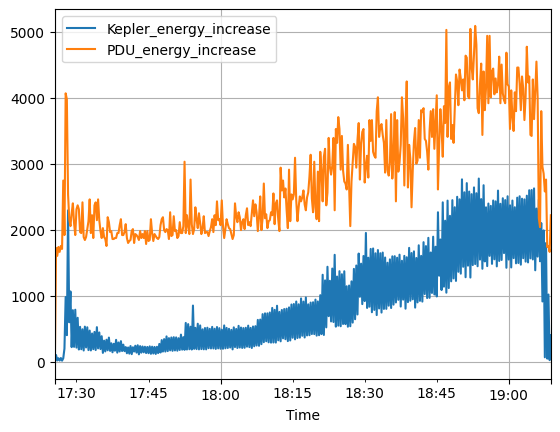

In [9]:
ax = merged_df.plot(x='Time', y=['Kepler_energy_increase','PDU_energy_increase'], kind='line', grid=True)
ax.figure.savefig(outputdir+'energy_diffs.png', bbox_inches='tight')

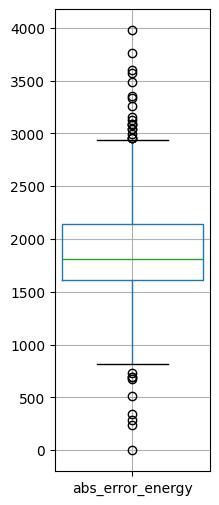

In [10]:
ax=merged_df.boxplot('abs_error_energy', widths=3, figsize=(2,6))
ax.figure.savefig(outputdir+'boxplot_energy_diffs_error.png', bbox_inches='tight')

# Calculate the energy consumption on each stage 

In [11]:
kepler_energy = []
pdu_energy = []
user_counts = []

# Loop through each stage
for stage in stages:
    stage_users = stage['users']
    stage_df = locust_df[locust_df['User Count'] == stage_users]
    
    # Append zeros for empty DataFrame and continue
    if stage_df.empty:
        logging.warning("The filtered DataFrame is empty. Ensure the time range is within the data bounds.")
        kepler_energy.append(0)
        pdu_energy.append(0)
        user_counts.append(stage_users)
        continue

    # Get the min and max index (time) for the current stage
    stage_start_time, stage_end_time = stage_df.index.min(), stage_df.index.max()
    # Convert the timezoned datetime to naive datetime (UTC or localize as needed)
    stage_start_time = stage_start_time.tz_convert("Europe/Berlin").tz_localize(None)
    end_time = stage_end_time.tz_convert("Europe/Berlin").tz_localize(None)
        
    k_energy, k_unit = calculate_kepler_energy_consumption(kepler_df, stage_start_time, end_time)
    p_energy, p_unit = calculate_pdu_energy_consumption(pdu_df, stage_start_time, end_time)
        
    logging.info(f"Stage: {stage_users}, From: {stage_start_time}, To: {end_time}, Kepler: {k_energy} {k_unit}, PDU: {p_energy} {p_unit}")
    
    kepler_energy.append(transform_joules(k_energy, k_unit, "kJ"))
    pdu_energy.append(transform_joules(p_energy, p_unit, "kJ"))
    user_counts.append(stage_users)

Stage: 100, From: 2024-08-10 17:27:17, To: 2024-08-10 17:46:27, Kepler: 23.94 kJ, PDU: 160.88 kJ
Stage: 200, From: 2024-08-10 17:48:08, To: 2024-08-10 18:06:28, Kepler: 25.079 kJ, PDU: 154.48 kJ
Stage: 300, From: 2024-08-10 18:08:08, To: 2024-08-10 18:26:27, Kepler: 50.777 kJ, PDU: 192.06 kJ
Stage: 400, From: 2024-08-10 18:28:08, To: 2024-08-10 18:46:27, Kepler: 93.609 kJ, PDU: 241.1 kJ
Stage: 500, From: 2024-08-10 18:48:08, To: 2024-08-10 19:06:28, Kepler: 143.052 kJ, PDU: 302.31 kJ


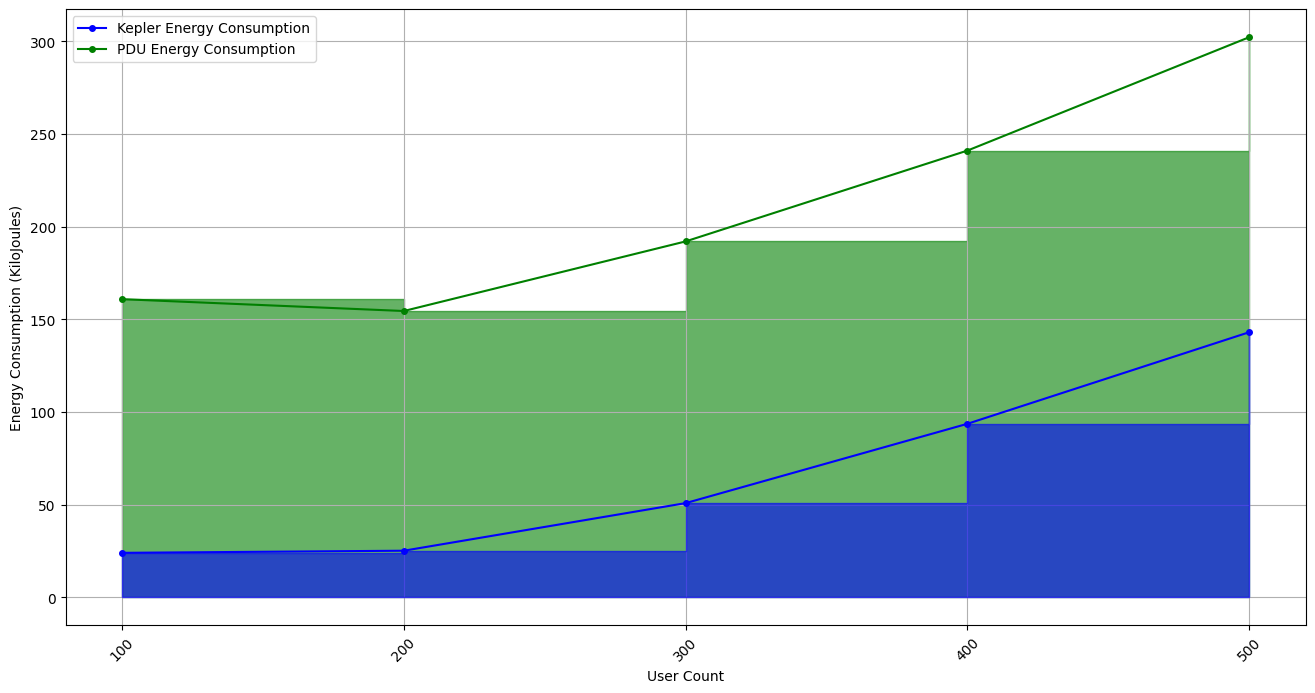

In [12]:
fig, ax = plt.subplots(figsize=(16, 8))

# Plot lines with markers to make data points visible
ax.plot(user_counts, kepler_energy, label='Kepler Energy Consumption', color='blue', marker='o', markersize=4, zorder=50)
ax.plot(user_counts, pdu_energy, label='PDU Energy Consumption', color='green', marker='o', markersize=4, zorder=50)

# Fill between for kepler energy
ax.fill_between(user_counts, kepler_energy, color='blue', alpha=0.6, step='post', zorder=5)

# Fill between for pdu energy
ax.fill_between(user_counts, pdu_energy, color='green', alpha=0.6, step='post', zorder=1)

# Additional Plot Settings
ax.set_xlabel('User Count')
ax.set_ylabel('Energy Consumption (KiloJoules)')
#ax.set_title('Energy Consumption by User Count Stage (Kepler vs PDU)')
# Set x-axis ticks and labels only to show user counts
ax.set_xticks(user_counts)
ax.set_xticklabels(user_counts)
ax.legend()
ax.grid(True)

plt.xticks(rotation=45)
plt.savefig(outputdir+'energy_consumption_by_stage.png', bbox_inches='tight')
plt.show()

# Calculate the usefully done work

In [13]:
def calculate_work_metrics_df():
    prometheus_metrics_df = pd.read_csv(service_metrics_data_file, parse_dates=['Time'])
    prometheus_metrics_df['Time'] = pd.to_datetime(prometheus_metrics_df['Time'])  # Ensure consistent timezone
    # Ensure the DataFrame is sorted by Time
    prometheus_metrics_df = prometheus_metrics_df.sort_values(by='Time')
    prometheus_metrics_df.index = pd.to_datetime(prometheus_metrics_df.index)
    for column in prometheus_metrics_df.columns:
        if column != 'Time':
            prometheus_metrics_df[column] = prometheus_metrics_df[column].ffill().fillna(0) # make values static on absence of data, not anymore absent    
    
    # Melt the DataFrame
    long_df = pd.melt(prometheus_metrics_df, id_vars=['Time'], var_name='Metric', value_name='Count')
    
    # Extract the application name
    def extract_application(metric):
        match = re.search(r'application="([^"]+)', metric)
        return match.group(1) if match else None
    
    long_df['Application'] = long_df['Metric'].apply(extract_application)
    
    # Convert 'Count' to numeric, ensuring invalid parsing will result in NaN, then fill them with 0
    long_df['Count'] = pd.to_numeric(long_df['Count'], errors='coerce').fillna(0)
    
    # Group by 'Time' and 'Application', and sum the 'Count'
    summed_df = long_df.groupby(['Time', 'Application'])['Count'].sum().reset_index()
    
    return summed_df.pivot(index='Time', columns='Application', values='Count').fillna(0)

service_work_metrics_df = calculate_work_metrics_df()
service_work_metrics_df

Application,FEEDSERVICE,GATEWAY,NOTIFICATIONSERVICE,POSTSERVICE,STATISTICSERVICE,USERSERVICE
Time,,,,,,
2024-08-10 17:26:28,0.0,0.0,0.0,0.0,0.0,0.0
2024-08-10 17:26:30,0.0,0.0,0.0,0.0,0.0,0.0
2024-08-10 17:26:32,0.0,0.0,0.0,0.0,0.0,0.0
2024-08-10 17:26:34,0.0,0.0,0.0,0.0,0.0,0.0
2024-08-10 17:26:36,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2024-08-10 19:10:30,572470.0,1882603.0,673569.0,822852.0,882261.0,979994.0
2024-08-10 19:10:32,572470.0,1882603.0,673569.0,822852.0,882261.0,979994.0
2024-08-10 19:10:34,572470.0,1882603.0,673569.0,822852.0,882261.0,979994.0


# Calculate the energy efficiency

Energy Efficiency = Useful Work / Consumed Energy

In [14]:
energy_efficiency_kepler = []
energy_efficiency_pdu = []
successful_requests_per_stage = []

# Loop through each stage
for stage in stages:
    stage_users = stage['users']
    stage_df = locust_df[locust_df['User Count'] == stage_users]
    
    # Get the min and max index (time) for the current stage
    stage_start_time, stage_end_time = stage_df.index.min(), stage_df.index.max()
    # Convert the timezoned datetime to naive datetime (localize to 'Europe/Berlin')
    stage_start_time = stage_start_time.tz_convert("Europe/Berlin").tz_localize(None)
    stage_end_time = stage_end_time.tz_convert("Europe/Berlin").tz_localize(None)
    
    # Filter service_work_metrics_df for the specified time range
    work_metrics_filtered = service_work_metrics_df[(service_work_metrics_df.index >= stage_start_time) & (service_work_metrics_df.index <= stage_end_time)]
    
    # Calculate successful requests
    successful_requests = work_metrics_filtered.max().sum()- work_metrics_filtered.min().sum()
    
    # Calculate energy efficiency (successful requests per kJ consumed)
    kepler_energy_consumed = kepler_energy[user_counts.index(stage_users)]
    pdu_energy_consumed = pdu_energy[user_counts.index(stage_users)]
    
    k_energy_efficiency = successful_requests / kepler_energy_consumed if kepler_energy_consumed != 0 else 0
    pdu_energy_efficiency = successful_requests / pdu_energy_consumed if pdu_energy_consumed != 0 else 0
    
    # Append results
    energy_efficiency_kepler.append(k_energy_efficiency)
    energy_efficiency_pdu.append(pdu_energy_efficiency)
    successful_requests_per_stage.append(successful_requests)
    logging.info(f"Stage: {stage_users}, From: {stage_start_time}, To: {stage_end_time}, Successfull Requests: {successful_requests} ,Kepler efficiency: {k_energy_efficiency}, PDU efficiency: {pdu_energy_efficiency}")

# Calculate total energy efficiency
total_successful_requests = sum(successful_requests_per_stage)
total_energy_kepler_kj = sum(kepler_energy)
total_energy_pdu_kj = sum(pdu_energy)

total_efficiency_kepler = total_successful_requests / total_energy_kepler_kj
total_efficiency_pdu = total_successful_requests / total_energy_pdu_kj

logging.info("Total Energy Efficiency (Kepler): %s successful requests/kJ", total_efficiency_kepler)
logging.info("Total Energy Efficiency (PDU): %s successful requests/kJ", total_efficiency_pdu)

total_efficiency_kepler = total_successful_requests / transform_joules(total_energy_kepler_kj,"kJ","J")
total_efficiency_pdu = total_successful_requests / transform_joules(total_energy_pdu_kj,"kJ","J")

logging.info("Total Energy Efficiency (Kepler): %s successful requests/J", total_efficiency_kepler)
logging.info("Total Energy Efficiency (PDU): %s successful requests/J", total_efficiency_pdu)

Stage: 100, From: 2024-08-10 17:27:17, To: 2024-08-10 17:46:27, Successfull Requests: 387003.0 ,Kepler efficiency: 16165.538847117794, PDU efficiency: 2405.5382894082545
Stage: 200, From: 2024-08-10 17:48:08, To: 2024-08-10 18:06:28, Successfull Requests: 767306.0 ,Kepler efficiency: 30595.55803660433, PDU efficiency: 4967.024857586743
Stage: 300, From: 2024-08-10 18:08:08, To: 2024-08-10 18:26:27, Successfull Requests: 1114341.0 ,Kepler efficiency: 21945.782539338677, PDU efficiency: 5802.04623555139
Stage: 400, From: 2024-08-10 18:28:08, To: 2024-08-10 18:46:27, Successfull Requests: 1449450.0 ,Kepler efficiency: 15484.088068454957, PDU efficiency: 6011.820821236001
Stage: 500, From: 2024-08-10 18:48:08, To: 2024-08-10 19:06:28, Successfull Requests: 1666912.0 ,Kepler efficiency: 11652.490003635043, PDU efficiency: 5513.9161787569055
Total Energy Efficiency (Kepler): 16005.05265160184 successful requests/kJ
Total Energy Efficiency (PDU): 5124.532036580608 successful requests/kJ
Total

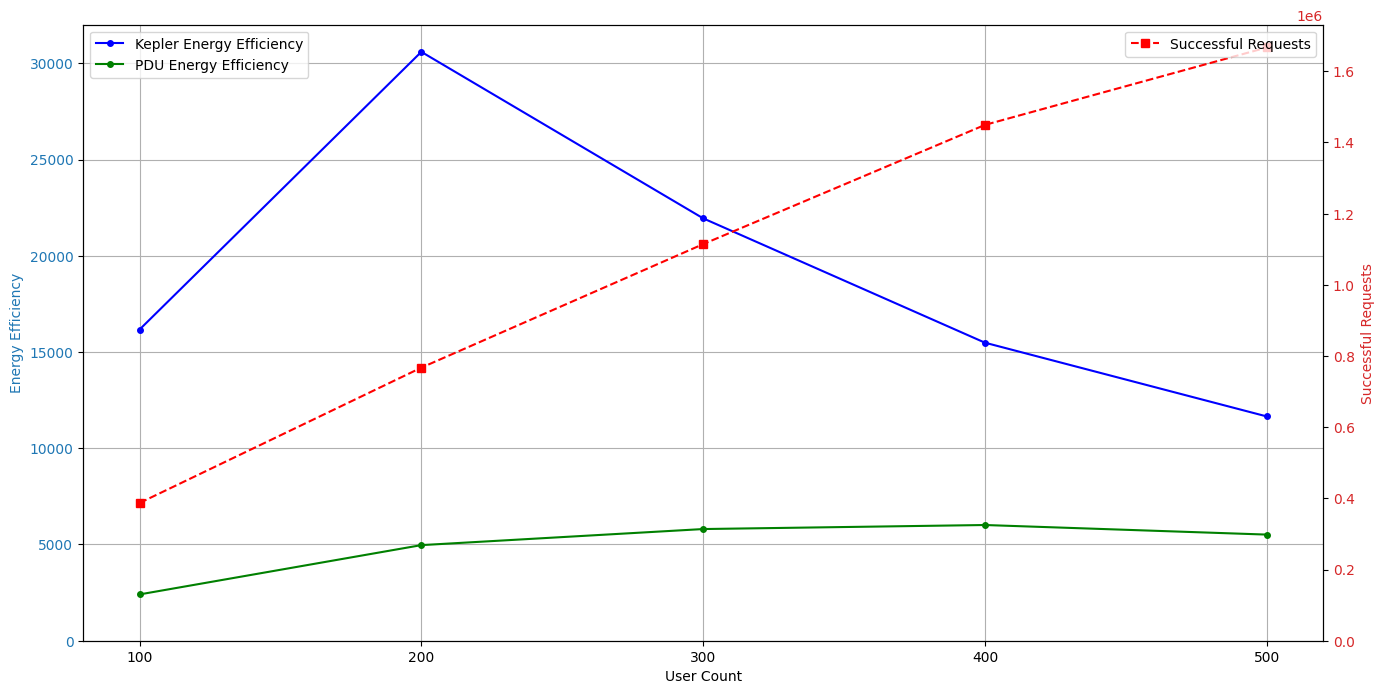

In [15]:
fig, ax1 = plt.subplots(figsize=(16, 8))

color = 'tab:blue'
ax1.set_xlabel('User Count')
ax1.set_ylabel('Energy Efficiency', color=color)

# Plot energy efficiency
ax1.plot(user_counts, energy_efficiency_kepler, label='Kepler Energy Efficiency', color='blue', marker='o', markersize=4)
ax1.plot(user_counts, energy_efficiency_pdu, label='PDU Energy Efficiency', color='green', marker='o', markersize=4)

ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(user_counts)
ax1.set_xticklabels(user_counts)
ax1.legend(loc='upper left')
ax1.grid()

# Ensure the y-axis starts at 0
ax1.set_ylim(bottom=0)

# Create second y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Successful Requests', color=color)

# Plot successful requests
ax2.plot(user_counts, successful_requests_per_stage, label='Successful Requests', color='red', marker='s', linestyle='--')

ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xticks(user_counts)
ax2.set_xticklabels(user_counts)
ax2.legend(loc='upper right')

# Ensure the y-axis starts at 0
ax2.set_ylim(bottom=0)

#plt.title('Energy Efficiency and Successful Requests by User Count Stage')
plt.xticks(rotation=45)
plt.savefig(outputdir+'energy_efficiency_by_stage.png', bbox_inches='tight')
plt.show()

# Calculate the energy efficiency of each service

as we have seen now how Kepler's trend of energy follows the pdu graph, we can use Kepler's data to look into our black box system and look at each service's energy efficiency.

In [16]:
# Filtere die DataFrame-Spalten, die `container_namespace="default"` enthalten
namespace_default_columns = [col for col in kepler_df.columns if 'container_namespace="default"' in col]

# Extrahiere den `container_name` aus den Headern und speichere ihn in einer neuen DataFrame-Spalte
service_names = [col.split('container_name="')[1].split('"')[0] for col in namespace_default_columns]
service_names = set(service_names)

def calculate_service_energy_consumption(kepler_df, service_name, start_time, end_time):
    # Ensure the DataFrame is sorted by Time
    kepler_df = kepler_df.sort_values(by='Time')
    
    # Filter only the columns related to the specific service
    service_columns = [col for col in kepler_df.columns if f'container_name="{service_name}"' in col]
    
    if not service_columns:
        logging.warning(f"No data available for service: {service_name}")
        return 0, "J"
    
    # Check if start_time is within the DataFrame's time range
    if start_time < kepler_df['Time'].min():
        logging.warning(f"Start time {start_time} is before the first timestamp. Using the first available value.")
        start_values = kepler_df.iloc[0][service_columns]
    else:
        start_values = kepler_df.loc[kepler_df['Time'] >= start_time].iloc[0][service_columns]

    # Check if end_time is within the DataFrame's time range
    if end_time > kepler_df['Time'].max():
        logging.warning(f"End time {end_time} is after the last timestamp. Using the last available value.")
        end_values = kepler_df.iloc[-1][service_columns]
    elif end_time < kepler_df['Time'].min():
        return 0, "J"
    else:
        end_values = kepler_df.loc[kepler_df['Time'] <= end_time].iloc[-1][service_columns]

    # Calculate the difference between end and start values
    energy_difference = end_values.values - start_values.values
    # Sum up the differences
    total_energy_sum = energy_difference.sum()
    
    # Convert to Joules
    energy, unit = convert_energy(total_energy_sum)

    return transform_joules(energy, unit, "J")

def calculate_metrics(service_list, start_time, end_time):
    metrics_results = {}
    for service in service_list:
        total_energy = calculate_service_energy_consumption(kepler_df, service, start_time, end_time)
        
        # Calculate successful request count from the service_work_metrics_df
        service_work_metrics_filtered = service_work_metrics_df[(service_work_metrics_df.index >= start_time) & (service_work_metrics_df.index <= end_time)]
        if service in set(map(str.lower,service_work_metrics_filtered.columns)):
            total_requests = service_work_metrics_filtered[service.upper()].max() - service_work_metrics_filtered[service.upper()].min()
        else:
            total_requests = 0
        
        failed_requests = 0
        
        successful_requests = total_requests - failed_requests
        efficiency = successful_requests / total_energy if total_energy != 0 else 0
        
        metrics_results[service] = {
            'efficiency': efficiency,
            'total_energy': total_energy,
            'successful_requests': successful_requests
        }
    
    return pd.DataFrame(metrics_results).transpose()

service_metrics = calculate_metrics(service_names, start_time, end_time)
service_metrics.to_latex(outputdir+'service_efficiency_energy_requests_table.tex', escape=True)
service_metrics

,efficiency,total_energy,successful_requests
zipkin,0.000000,1483.0,0.0
userservice-db,0.000000,124305.0,0.0
postservice,25.184250,32597.0,820931.0
prometheus,0.000000,4096.0,0.0
gateway,216.736994,8669.0,1878893.0
feedservice,26.839594,21296.0,571576.0
feedservice-db,0.000000,5851.0,0.0
postservice-db,0.000000,41876.0,0.0
statisticservice,44.635102,19737.0,880963.0
rabbitmq,0.000000,3727.0,0.0


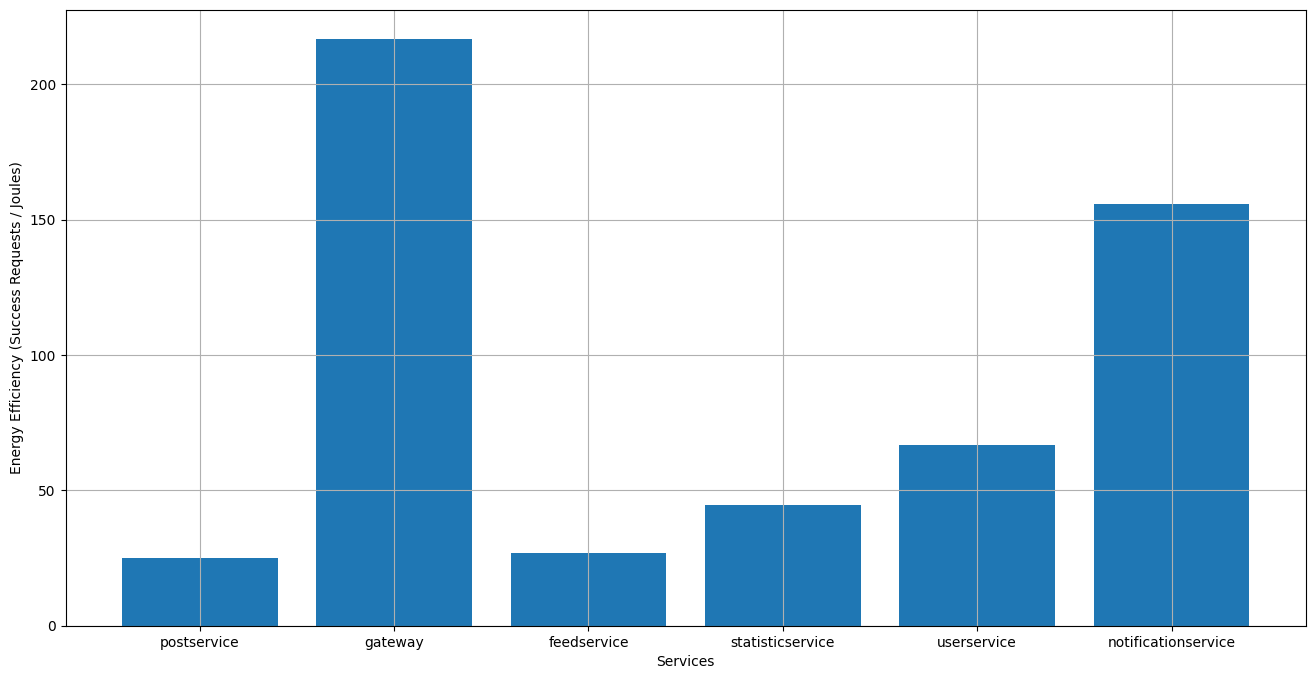

In [17]:
# Visualisierung der Ergebnisse
fig, ax = plt.subplots(figsize=(16, 8))

filtered_service_metrics = service_metrics[service_metrics['efficiency'] > 0]
ax.bar(filtered_service_metrics.index, filtered_service_metrics["efficiency"])

ax.set_xlabel('Services')
ax.set_ylabel('Energy Efficiency (Success Requests / Joules)')
#ax.set_title('Energy Efficiency per Service')
ax.grid(True)

plt.savefig(outputdir+'energy_efficiency_by_service.png', bbox_inches='tight')
plt.show()

### It makes sense to add the database energy consumption to each service as the generated load and useful done work is associated with this energy

In [18]:
combined_metrics = service_metrics[
    (~service_metrics.index.str.endswith('-db')) | (service_metrics.index == 'redis')
].copy()

# Add DB energy consumption to the respective services
combined_metrics['total_energy'] += combined_metrics.apply(
    lambda row: service_metrics.loc[f"{row.name}-db", 'total_energy'] if f"{row.name}-db" in service_metrics.index else 0, axis=1
)
if add_redis_to_feedservice:
    combined_metrics.loc['feedservice', 'total_energy'] += service_metrics.loc['redis', 'total_energy']
# Calculate efficiency
combined_metrics['efficiency'] = combined_metrics['successful_requests'] / combined_metrics['total_energy']
combined_metrics.to_latex(outputdir+'service_merged_with_database_efficiency_energy_requests_table.tex', escape=True)
combined_metrics

,efficiency,total_energy,successful_requests
zipkin,0.000000,1483.0,0.0
postservice,11.023203,74473.0,820931.0
prometheus,0.000000,4096.0,0.0
gateway,216.736994,8669.0,1878893.0
feedservice,20.278720,28186.0,571576.0
statisticservice,21.415344,41137.0,880963.0
rabbitmq,0.000000,3727.0,0.0
userservice,7.025781,138938.0,976148.0
notificationservice,11.390650,56790.0,646875.0
servicediscovery,0.000000,346.0,0.0


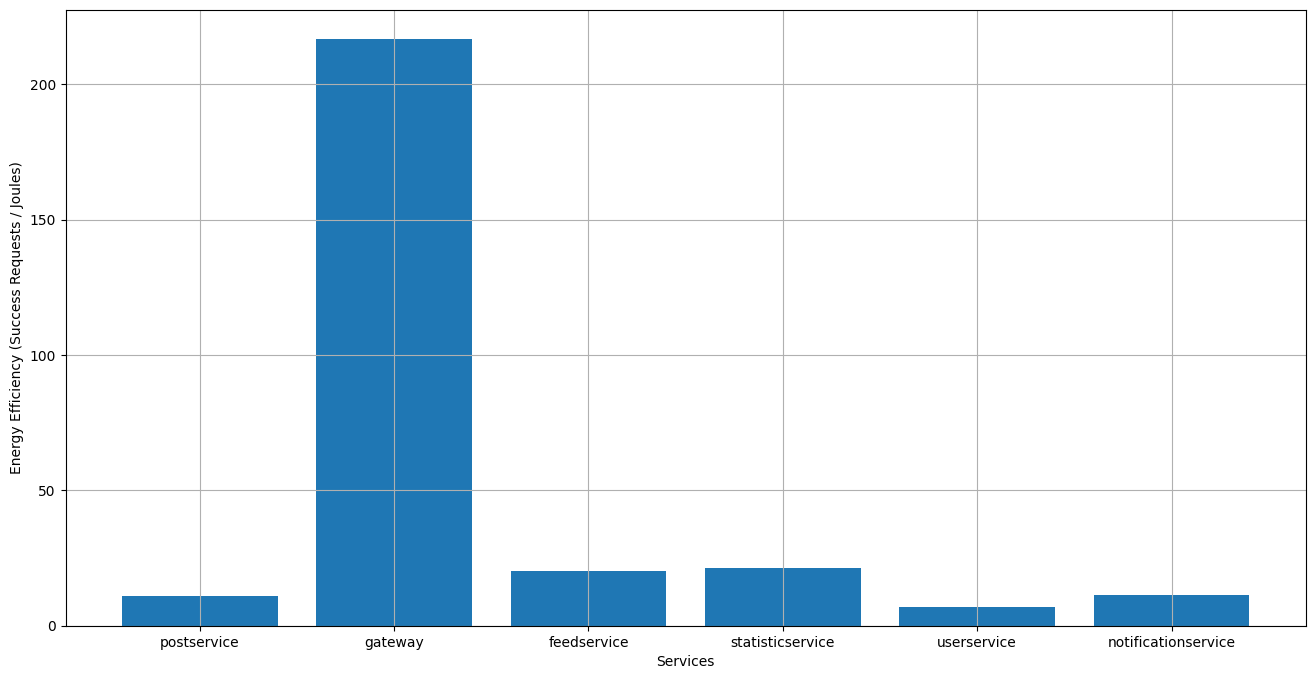

In [19]:
filtered_combined_metrics = combined_metrics[combined_metrics['efficiency'] > 0]

fig, ax = plt.subplots(figsize=(16, 8))
ax.bar(filtered_combined_metrics.index, filtered_combined_metrics["efficiency"])
ax.set_xlabel('Services')
ax.set_ylabel('Energy Efficiency (Success Requests / Joules)')
#ax.set_title('Energy Efficiency per Service (Including DB Consumption)')
ax.grid(True)

plt.savefig(outputdir+'energy_efficiency_by_service_merged_with_database.png', bbox_inches='tight')
plt.show()

# Calculate the energy efficiency of each service (including their DB) over each stage

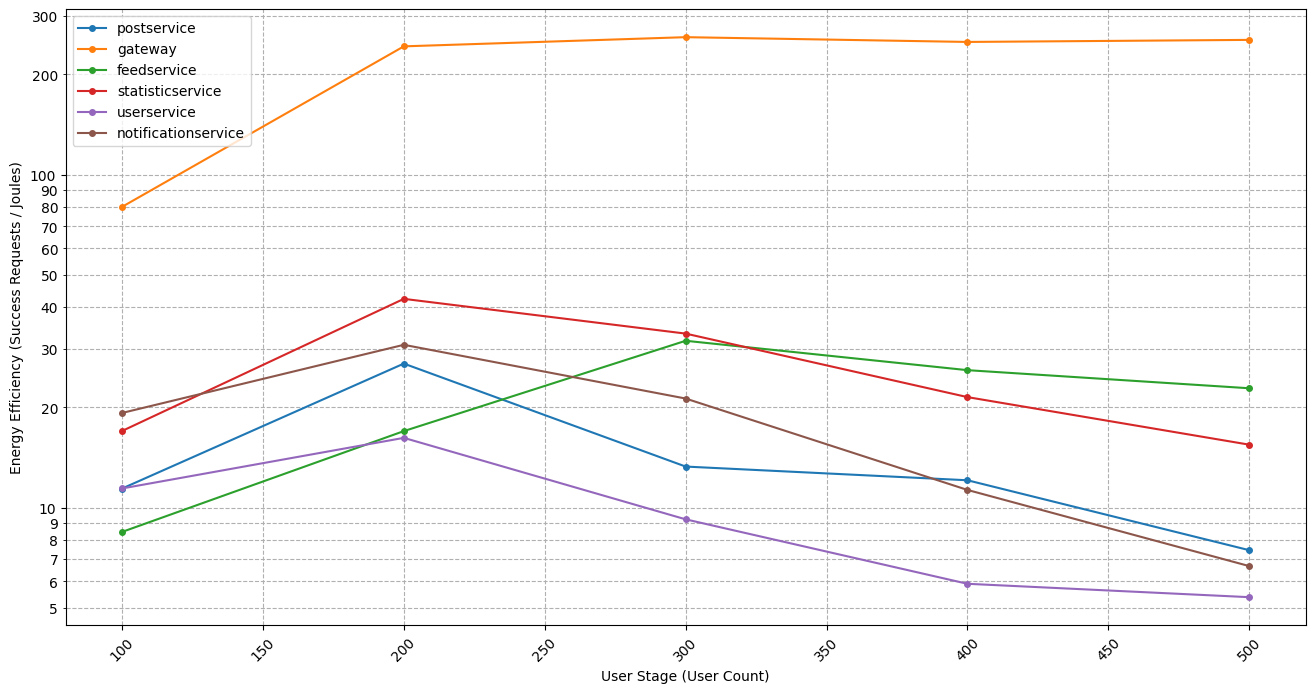

In [20]:
# Function to calculate energy consumption for each service during stages
def calculate_combined_service_metrics_by_stage(service_list, stages, locust_df, kepler_df, service_work_metrics_df, add_redis_to_feedservice=False):
    metrics_results_by_stage = {stage['users']: {} for stage in stages}

    for stage in stages:
        stage_users = stage['users']
        stage_df = locust_df[locust_df['User Count'] == stage_users]

        # Get the min and max index (time) for the current stage
        if stage_df.empty:
            logging.warning("No data available for stage " + stage)
            for service in service_list:
                metrics_results_by_stage[stage_users][service] = {
                    'efficiency': 0,
                    'total_energy': 0,
                    'successful_requests': 0,
                }
            continue

        stage_start_time, stage_end_time = stage_df.index.min(), stage_df.index.max()
        stage_start_time = stage_start_time.tz_convert("Europe/Berlin").tz_localize(None)
        stage_end_time = stage_end_time.tz_convert("Europe/Berlin").tz_localize(None)

        stage_work_metrics_df = service_work_metrics_df[
            (service_work_metrics_df.index >= stage_start_time) & (service_work_metrics_df.index <= stage_end_time)]

        for service in service_list:
            if service.endswith('-db'):
                continue  # Skip DB services

            total_energy_service = calculate_service_energy_consumption(kepler_df, service, stage_start_time,
                                                                        stage_end_time)
            if f"{service}-db" in service_list:
                total_energy_service += calculate_service_energy_consumption(kepler_df, f"{service}-db", stage_start_time, stage_end_time)

            if add_redis_to_feedservice and service == 'feedservice' and 'redis' in service_list:
                total_energy_service += calculate_service_energy_consumption(kepler_df, 'redis', stage_start_time, stage_end_time)

            if service.upper() in set(map(str.upper, stage_work_metrics_df.columns)):
                total_requests = stage_work_metrics_df[service.upper()].max() - stage_work_metrics_df[
                    service.upper()].min()
            else:
                total_requests = 0

            successful_requests = total_requests
            efficiency = successful_requests / total_energy_service if total_energy_service != 0 else 0

            metrics_results_by_stage[stage_users][service] = {
                'efficiency': efficiency,
                'total_energy': total_energy_service,
                'successful_requests': successful_requests,
            }

    return metrics_results_by_stage


service_metrics_by_stage = calculate_combined_service_metrics_by_stage(service_names, stages, locust_df, kepler_df,
                                                                       service_work_metrics_df, add_redis_to_feedservice)

# Convert dictionary to DataFrame for easier manipulation
metrics_df_list = []

for user_stage, service_metrics in service_metrics_by_stage.items():
    df = pd.DataFrame(service_metrics).transpose()
    df['user_stage'] = user_stage
    metrics_df_list.append(df)

staged_service_metrics_df = pd.concat(metrics_df_list)

# Filter out services with zero efficiency
staged_service_metrics_df = staged_service_metrics_df[staged_service_metrics_df['efficiency'] > 0]

# Plot Efficiency of each combined service over stages
fig, ax = plt.subplots(figsize=(16, 8))

# Plot data
for service in staged_service_metrics_df.index.unique():
    filtered_df = staged_service_metrics_df.loc[staged_service_metrics_df.index == service]
    ax.plot(filtered_df['user_stage'], filtered_df['efficiency'], label=service, marker='o', markersize=4)

# Set labels for axes
ax.set_xlabel('User Stage (User Count)')
ax.set_ylabel('Energy Efficiency (Success Requests / Joules)')

# Set x-ticks with more labels
user_counts = [stage['users'] for stage in stages]
ax.set_xticks(user_counts)

# Adding intermediate x-ticks for better granularity
additional_ticks = [int((user_counts[i] + user_counts[i+1])/2) for i in range(len(user_counts)-1)]
all_ticks = sorted(user_counts + additional_ticks)
ax.set_xticks(all_ticks)

# Set x-tick labels
ax.set_xticklabels(all_ticks)

# Set y-axis to logarithmic scale
ax.set_yscale('log')

# Customizing y-axis ticks for more labels
ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto', numticks=20))

# Formatter for the major ticks
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
ax.yaxis.set_minor_formatter(ticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

# Adding legend and grid lines
ax.legend(loc='upper left')
ax.grid(True, which='both', linestyle='--')

# Enhance the readability of x-ticks by rotating
plt.xticks(rotation=45)

# Save figure and show
plt.savefig(outputdir + 'energy_efficiency_by_service_by_stage.png', bbox_inches='tight')
plt.show()

In [21]:
logging.info("Finished")

Finished
